<a href="https://colab.research.google.com/github/KOdunga/AIMLCourse/blob/main/Copy_of_KenCVAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
 <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>



<h1><center><font size=6></font></center></h1>
<h1><center> Artificial Intelligence and Machine Learning </center></h1>
<h1><center> Computer Vision - Assignment 1 </center></h1>

## **Problem Statement**
### **Context**
In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.
### **Objective**
The aim of this project is to Build a Convolutional Neural Network to classify plant seedlings into their respective categories.
### **Data Dictionary**
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that we can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: We will use GPU runtime on Google Colab to help execute the code faster.**

**Importing necessary libraries**

In [55]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs

# Importing the preprocessing module to preprocess the data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
#Import Sklearn metrics
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model




#Importing transfer learning modules
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16


# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images



# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Loading the dataset**

In [3]:
# Mount Google drive to access the dataset (monkeys_dataset.zip)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Computer Vision/Assignment 1/images.npy')
# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Computer Vision/Assignment 1/Labels.csv')

## Data Overview

**Understand the shape of the dataset**

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are **4,750** RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Exploratory Data Analysis

**Plotting images using OpenCV and Matplotlib**

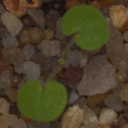

In [6]:
cv2_imshow(images[5])

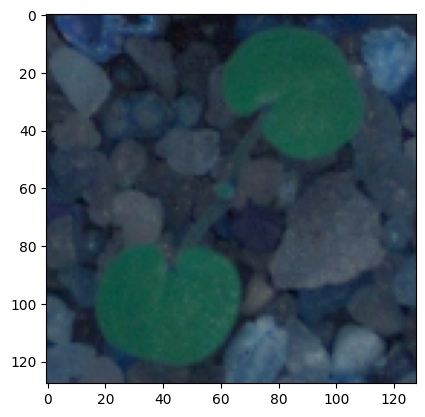

In [7]:
plt.imshow(images[5]);

- We observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- We will convert these BGR images to RGB images so we could interpret them easily.

**Checking the distribution of the target variable to see if data is imbalanced**

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

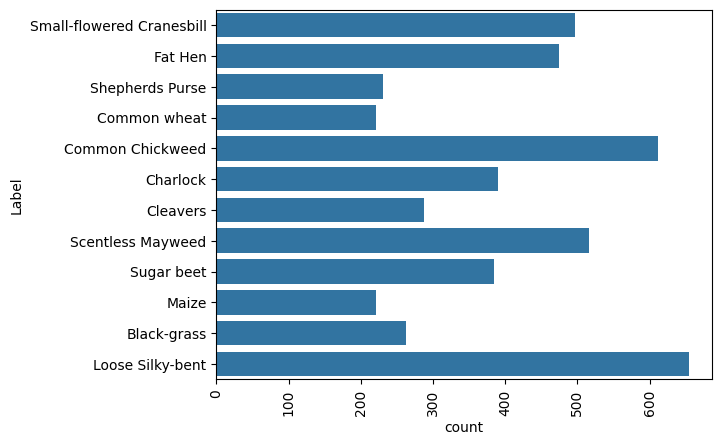

In [49]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical');

- As we can see from the above plot, the dataset is quite imbalanced.
- Each category has atleast over 200 images, with some categories having as high as over 600 images.
- We will try to predict with the current dataset and also perfoam data augmentation to generate new information and check if the perfomance will improve.

### Data Preparation for Modeling

**Converting the images from BGR to RGB using cvtColor function of OpenCV**

In [ ]:

for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

**Plotting random images from each of the class**

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

In [ ]:
plot_images(images,labels)

**Resizing images**


As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [12]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

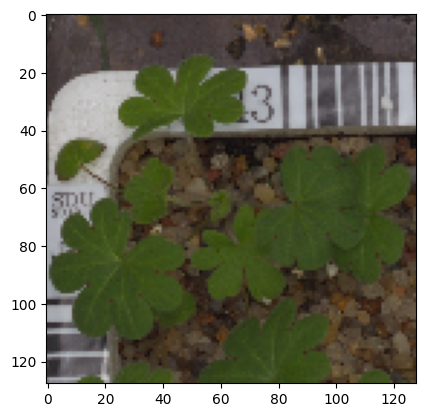

In [51]:
plt.imshow(images[3])

**Image after resizing**

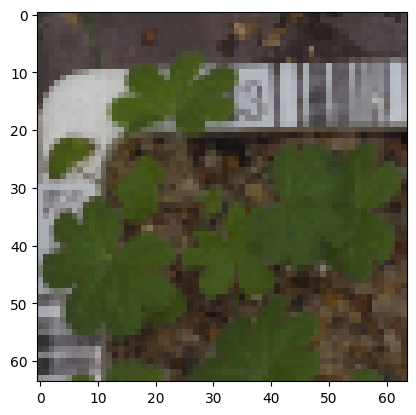

In [50]:
plt.imshow(images_decreased[3]);

**Visualizing images using Gaussian Blur**

In [14]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

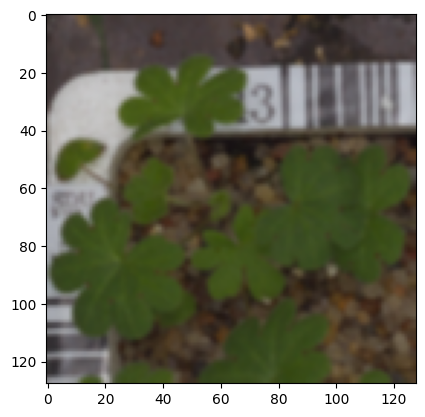

In [15]:
plt.imshow(images_gb[3]);

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

### Data Preparation for Modeling

- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

**Splitting the dataset**

In [16]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [17]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Making the data compatible:

- Convert labels from names to one hot vectors
- Normalizing the values

**Encoding the target labels**

In [18]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

**Data Normalization**

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [19]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

**Model 1: Convolutional Neural Network (CNN)**
- Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

In [20]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>

**Model build up**

In [22]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

**Fitting the model on the train data**

In [23]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 7s - loss: 2.4514 - accuracy: 0.1289 - val_loss: 2.3953 - val_accuracy: 0.1612 - 7s/epoch - 57ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3076 - accuracy: 0.1775 - val_loss: 2.1705 - val_accuracy: 0.2266 - 699ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 2.1099 - accuracy: 0.2441 - val_loss: 1.9681 - val_accuracy: 0.3411 - 714ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9972 - accuracy: 0.2854 - val_loss: 1.8295 - val_accuracy: 0.3505 - 896ms/epoch - 7ms/step
Epoch 5/30
121/121 - 1s - loss: 1.9703 - accuracy: 0.2831 - val_loss: 1.7730 - val_accuracy: 0.3528 - 987ms/epoch - 8ms/step
Epoch 6/30
121/121 - 1s - loss: 1.9437 - accuracy: 0.2846 - val_loss: 1.7718 - val_accuracy: 0.3575 - 909ms/epoch - 8ms/step
Epoch 7/30
121/121 - 1s - loss: 1.9383 - accuracy: 0.2820 - val_loss: 1.7448 - val_accuracy: 0.3668 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 1.8928 - accuracy: 0.3013 - val_loss: 1.6985 - val_accuracy: 0.3621 - 1s/epoch - 11ms/step
Epoch 

**Model Evaluation**

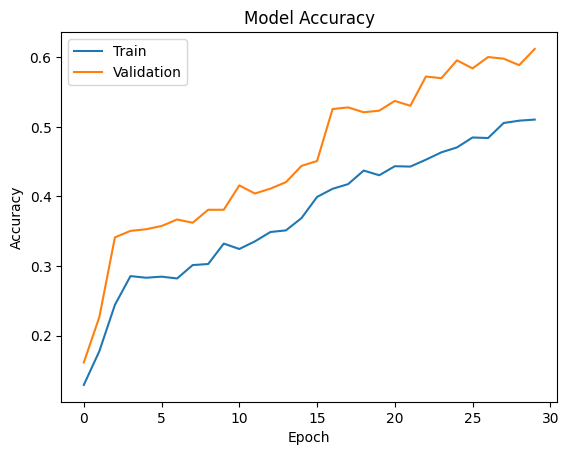

In [24]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the validation accuracy of the  model was good but the training accuracy was not good.**
*   The model seems to overfit on the data as the difference between the training and validation accuracies is huge.

**Evaluating the model on test data**

In [25]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2303 - accuracy: 0.5747 - 230ms/epoch - 15ms/step


**Generating the predictions using test data**

In [26]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


In [27]:
y_pred

array([[5.0737935e-11, 1.2695953e-06, 9.9852615e-10, ..., 2.6249202e-02,
        4.2098127e-02, 3.4776627e-04],
       [2.1583060e-07, 6.1273992e-02, 1.5125822e-01, ..., 9.8232962e-03,
        7.2662383e-01, 4.7825091e-02],
       [2.2295162e-05, 3.7746143e-04, 1.7113386e-03, ..., 1.3840391e-02,
        7.4921739e-01, 1.5293969e-01],
       ...,
       [2.0857939e-01, 5.2475060e-09, 1.5659394e-06, ..., 3.8797325e-09,
        5.5627393e-06, 2.1340935e-04],
       [1.7885856e-03, 1.0461931e-01, 7.4534751e-02, ..., 6.9198109e-02,
        3.1579450e-02, 8.1604764e-02],
       [3.6243524e-05, 9.1095291e-02, 2.6558900e-01, ..., 2.6053630e-02,
        4.3935376e-01, 1.4358789e-01]], dtype=float32)

**Plotting the Confusion Matrix**

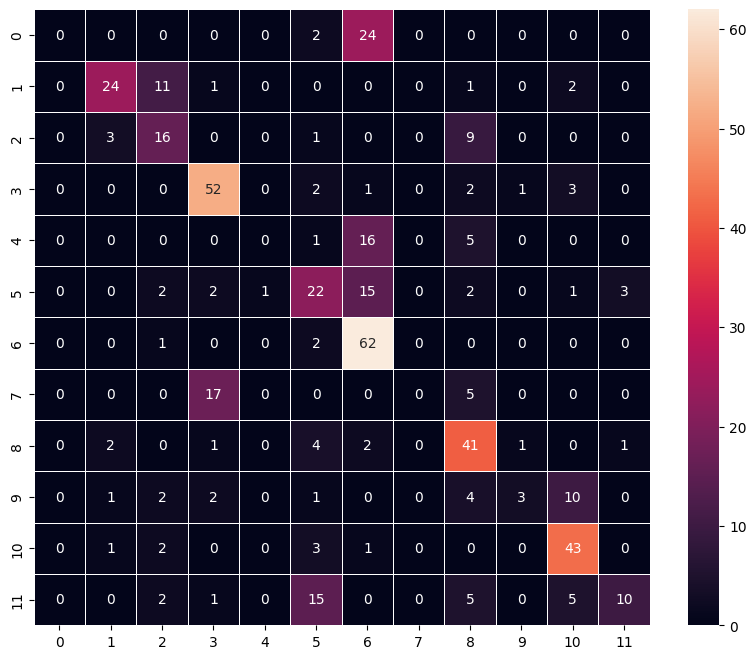

In [28]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Plotting the Classification Report**

In [54]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.53      0.31      0.39        26
           1       0.50      0.51      0.51        39
           2       0.48      0.45      0.46        29
           3       0.76      0.67      0.71        61
           4       0.00      0.00      0.00        22
           5       0.49      0.50      0.49        48
           6       0.53      0.94      0.67        65
           7       0.79      0.50      0.61        22
           8       0.64      0.58      0.61        52
           9       0.12      0.04      0.06        23
          10       0.51      0.74      0.60        50
          11       0.65      0.53      0.58        38

    accuracy                           0.56       475
   macro avg       0.50      0.48      0.48       475
weighted avg       0.54      0.56      0.53       475



<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 0,4, 7 and 9 are well classified.
- We can also observe that classes 1,2,3,5,6,8,10 and 11 are mostly misclassified.

**Model 2: Convolutional Neural Network (CNN) with Data Augmentation**

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

## **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

**Data augmentation should not be used in the validation/test data set**.

**Clearing the backend and fixing the random seed**

In [29]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Image data generation for augmentation purposes**

In [30]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

**Model build up**

In [31]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

**Fitting the model on the train data**

In [32]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 8s 96ms/step - loss: 2.1450 - accuracy: 0.2387 - val_loss: 2.3732 - val_accuracy: 0.2033
Epoch 2/25
60/60 [==============================] - 10s 172ms/step - loss: 1.7157 - accuracy: 0.4044 - val_loss: 2.2642 - val_accuracy: 0.2734
Epoch 3/25
60/60 [==============================] - 7s 122ms/step - loss: 1.4856 - accuracy: 0.4711 - val_loss: 2.2608 - val_accuracy: 0.2150
Epoch 4/25
60/60 [==============================] - 8s 133ms/step - loss: 1.3945 - accuracy: 0.5107 - val_loss: 2.0751 - val_accuracy: 0.3995
Epoch 5/25
60/60 [==============================] - 7s 109ms/step - loss: 1.3012 - accuracy: 0.5398 - val_loss: 1.9931 - val_accuracy: 0.3598
Epoch 6/25
60/60 [==============================] - 9s 148ms/step - loss: 1.2216 - accuracy: 0.5636 - val_loss: 1.6449 - val_accuracy: 0.5491
Epoch 7/25
60/60 [==============================] - 5s 81ms/step - loss: 1.1679 - accuracy: 0.5842 - val_loss: 1.4264 - val_accuracy: 0.5421
Epoch 8

**Model Evaluation**

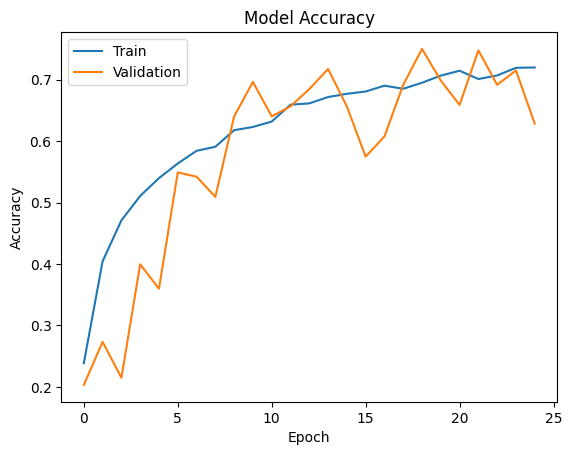

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**
*   We can see from the above plot that **the training accuracy of the  model has improved  and validation accuracy is also good.**
*   The overfiting problem in the first model seems to have been resolved.


**Evaluating the model on test data**

In [56]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1859 - accuracy: 0.6400 - 66ms/epoch - 4ms/step


**Generating the predictions using test data**

In [57]:
# Here we would get the output as probablities for each category
y_pred_2=model.predict(X_test_normalized)

15/15 [==============================] - 0s 4ms/step


**Plotting the Confusion Matrix**

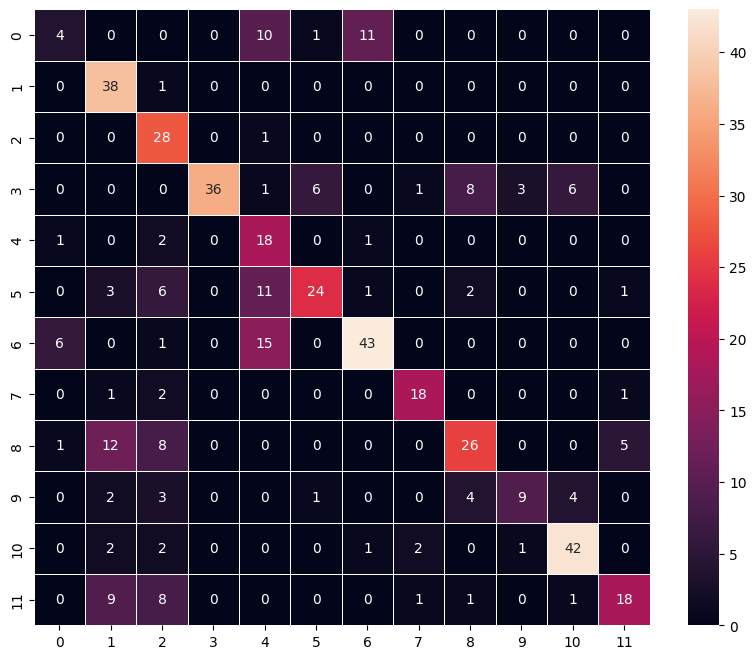

In [58]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_2=np.argmax(y_pred_2,axis=1)
y_test_arg_2=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg_2,y_pred_arg_2)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Classification Report**

In [59]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg_2,y_pred_arg_2)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.15      0.21        26
           1       0.57      0.97      0.72        39
           2       0.46      0.97      0.62        29
           3       1.00      0.59      0.74        61
           4       0.32      0.82      0.46        22
           5       0.75      0.50      0.60        48
           6       0.75      0.66      0.70        65
           7       0.82      0.82      0.82        22
           8       0.63      0.50      0.56        52
           9       0.69      0.39      0.50        23
          10       0.79      0.84      0.82        50
          11       0.72      0.47      0.57        38

    accuracy                           0.64       475
   macro avg       0.65      0.64      0.61       475
weighted avg       0.70      0.64      0.64       475



<b> Observations</b><br>
- The accuracy of the model has improved from 56% to 64%

# Transfer Learning using VGG16

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

**VGG Model Summary**

In [37]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

**Making all the layers of the VGG model non-trainable**

In [38]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

**Model Build up**

In [39]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 12)                204       
                                                                 
Total params: 14780988 (56.38 MB)
Trainable params: 66

**Fitting the model on the training data**

In [40]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 12s 147ms/step - loss: 2.3819 - accuracy: 0.1644 - val_loss: 2.2586 - val_accuracy: 0.2827
Epoch 2/25
60/60 [==============================] - 8s 138ms/step - loss: 2.1709 - accuracy: 0.2712 - val_loss: 2.0446 - val_accuracy: 0.3762
Epoch 3/25
60/60 [==============================] - 5s 88ms/step - loss: 1.9579 - accuracy: 0.3431 - val_loss: 1.8623 - val_accuracy: 0.3668
Epoch 4/25
60/60 [==============================] - 6s 95ms/step - loss: 1.7986 - accuracy: 0.3777 - val_loss: 1.7707 - val_accuracy: 0.3879
Epoch 5/25
60/60 [==============================] - 6s 91ms/step - loss: 1.7047 - accuracy: 0.3984 - val_loss: 1.6618 - val_accuracy: 0.3972
Epoch 6/25
60/60 [==============================] - 5s 84ms/step - loss: 1.6284 - accuracy: 0.4272 - val_loss: 1.6107 - val_accuracy: 0.4439
Epoch 7/25
60/60 [==============================] - 6s 108ms/step - loss: 1.5909 - accuracy: 0.4330 - val_loss: 1.5527 - val_accuracy: 0.4556
Epoch 8/2

**Model Evaluation**

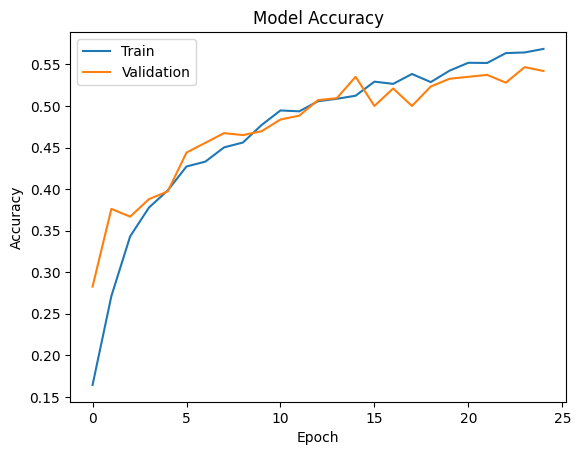

In [41]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluating the model on test data**

In [60]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.3009 - accuracy: 0.5600 - 309ms/epoch - 21ms/step


**Generating predictions using the test data**

In [61]:
# Here we would get the output as probablities for each category
y_pred_3=new_model.predict(X_test_normalized)

15/15 [==============================] - 0s 13ms/step


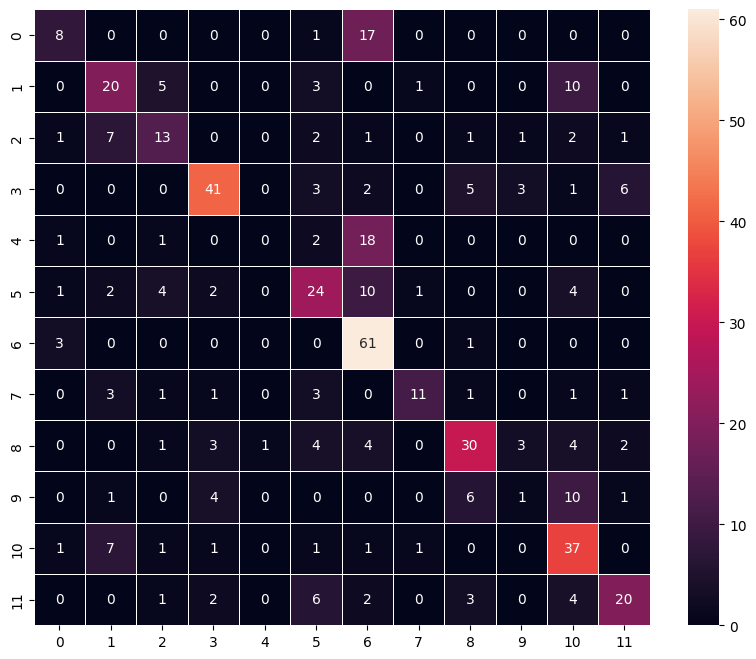

In [62]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_3=np.argmax(y_pred,axis=1)
y_test_arg_3=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg_3,y_pred_arg_3)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Classification Report**

In [63]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg_3,y_pred_arg_3)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.53      0.31      0.39        26
           1       0.50      0.51      0.51        39
           2       0.48      0.45      0.46        29
           3       0.76      0.67      0.71        61
           4       0.00      0.00      0.00        22
           5       0.49      0.50      0.49        48
           6       0.53      0.94      0.67        65
           7       0.79      0.50      0.61        22
           8       0.64      0.58      0.61        52
           9       0.12      0.04      0.06        23
          10       0.51      0.74      0.60        50
          11       0.65      0.53      0.58        38

    accuracy                           0.56       475
   macro avg       0.50      0.48      0.48       475
weighted avg       0.54      0.56      0.53       475



<b> Observations</b><br>
- The accuracy of the model has dropped from 64% to 56%

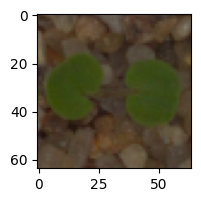

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


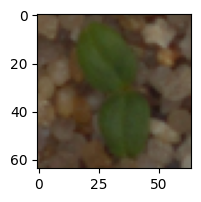

1/1 [==============================] - 0s 23ms/step
Predicted Label ['Fat Hen']
True Label Cleavers


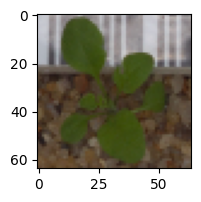

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Charlock']
True Label Shepherds Purse


In [46]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Conclusion
- We can observe from the confusion matrix of all the models that the CNN model with data augmentation was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the CNN model with data augmentation is 64%.
- Data Augmentation has helped in improving the model.

In [64]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],
              'Train Accuracy':['51%','72%','57%'],'Validation Accuracy':['61%','63%','54%'],'Test Accuracy':['57%','64%','56%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,51%,61%,57%
1,CNN Model with Data Augmentation,72%,63%,64%
2,Transfer Learning Model,57%,54%,56%


## Actionable Insights and Business Recommendations

- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

**At an accuracy rate of 64%, we can deploy the second model for operations and monitor it's perfomance over time.**